Variable definitions

    DATOP - Date of flight
    FLTID - Flight number
    DEPSTN - Departure point
    ARRSTN - Arrival point
    STD - Scheduled Time departure
    STA - Scheduled Time arrival
    STATUS - Flight status
    ETD - Expected Time departure
    ETA - Expected Time arrival
    ATD - Actual Time of Departure
    ATA - Actual Time of arrival
    DELAY1 - Delay code 1
    DUR1 - delay time 1
    DELAY2 - Delay code 2
    DUR2 - delay time 2
    DELAY3 - Delay code 3
    DUR3 - delay time 3
    DELAY4 - Delay code 4
    DUR4 - delay time 4
    AC - Aircraft Code


In [1]:
#import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import pickle


In [2]:
# load data (cleaned with preprocess_data.ipynb)
with open('data/clean_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train            = loaded_data[0]
X_test             = loaded_data[1]
y_train            = loaded_data[2]
y_test             = loaded_data[3]
discarded_features = loaded_data[4]
scaler             = loaded_data[5]

## Break the problem down into a classification task

In [3]:
# make target binary to solve classificaiton task
y_train = y_train > 0
y_test  = y_test > 0

In [5]:
#fit classification model

from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=1234,
    enable_categorical=True
)

parameters = {
    'n_estimators':     range(150, 250, 50),
    'max_depth':        range(2, 10, 2),
    'learning_rate':    [.1, .2, .3, .4],
    'colsample_bytree': [.7, .8, .9, 1]
}

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1234)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1234)

scorer = make_scorer(fbeta_score,beta=1) #lower beta puts more emphasis on recall
#scorer = 'accuracy'

Grid_search  = GridSearchCV(
                            estimator=estimator,
                            param_grid=parameters,
                            scoring = scorer,
                            n_jobs = -1,
                            cv = cv,
                            verbose=True
                            )

# execute Random search
Grid_search.fit(X_train, y_train)

#make predictions using the trained model
y_pred_train = Grid_search.predict(X_train)
y_pred       = Grid_search.predict(X_test)

# save model to file so we don't have to run it again
with open('models/xgboost_classifier.pkl','wb') as f:
    pickle.dump(Grid_search,f)    

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [ ]:
print(Grid_search.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}


## Evaluate the model

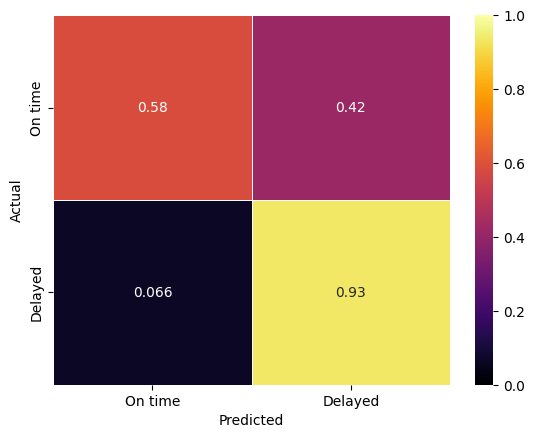

Training Set Performance:
              precision    recall  f1-score   support

       False       0.86      0.61      0.71     30523
        True       0.82      0.95      0.88     55705

    accuracy                           0.83     86228
   macro avg       0.84      0.78      0.80     86228
weighted avg       0.83      0.83      0.82     86228


Testing Set Performance:
              precision    recall  f1-score   support

       False       0.83      0.58      0.69      7607
        True       0.80      0.93      0.86     13960

    accuracy                           0.81     21567
   macro avg       0.82      0.76      0.77     21567
weighted avg       0.81      0.81      0.80     21567



In [ ]:
cfm = confusion_matrix(y_test, y_pred,normalize='true')
fig = sns.heatmap(cfm, cmap='inferno', annot=True, vmin=0, vmax = 1, linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks([0.5, 1.5],['On time', 'Delayed'])
plt.yticks([0.5, 1.5],['On time', 'Delayed'])

plt.savefig('./plots/Classifier_cfm.png', bbox_inches='tight',transparent=True)
plt.show()

print("Training Set Performance:")
print(classification_report(y_train, y_pred_train))
print("\nTesting Set Performance:")
print(classification_report(y_test, y_pred))

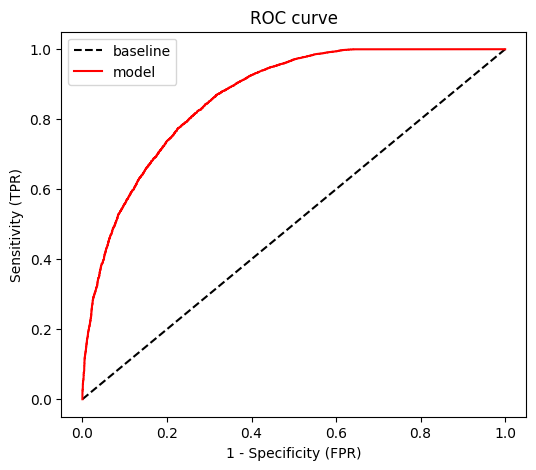

In [ ]:
#calculate probabilities
from sklearn.metrics import roc_curve


y_prob_train = Grid_search.predict_proba(X_train)
y_prob_test =  Grid_search.predict_proba(X_test)

#calculate baseline and model ROC curves
base_fpr,  base_tpr,  _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_prob_test[:,1])
    
#plot ROC curves
plt.figure(figsize = (6, 5))
plt.plot(base_fpr, base_tpr, 'k--', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC curve')
plt.savefig('./plots/Classifier_ROC.png', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print(f'Train ROC AUC Score: {roc_auc_score(y_train, y_prob_train[:,1])}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test,  y_prob_test[:,1])}')

Train ROC AUC Score: 0.8949448033735946
Test ROC AUC  Score: 0.8646339256219671
